<a href="https://colab.research.google.com/github/markinaan/NeuroBarometer/blob/master/sparse_data_prediction_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from tqdm import tqdm

In [ ]:
df = pd.read_csv('full_sparse_data_all_features.csv')

In [ ]:
pd.set_option('display.max_rows', None)
non_null_counts = {col: df[col].notnull().sum() for col in df.columns}
non_null_df = pd.DataFrame(list(non_null_counts.items()), columns=['Column', 'Non-Null Count'])
print(non_null_df)

                                       Column  Non-Null Count
0                                     user_id        12856432
1                                      gender        12856192
2                                         age        12856199
3                                        date        12856432
4                           next_day_migraine          594117
5                                migraine_day          630939
6                                  pain_level          671223
7                                 absenteeism          143678
8                over_the_counter_not_helpful          112949
9                    over_the_counter_helpful          112949
10                        triptan_not_helpful          112949
11                            triptan_helpful          112949
12                         nurtec_not_helpful          112949
13                             nurtec_helpful          112949
14                        ubrelvy_not_helpful          112949
15      

In [ ]:
df['migraine_day'].value_counts()

migraine_day
1.0    454641
0.0    176298
Name: count, dtype: int64

In [ ]:
df['next_day_migraine'].value_counts()

next_day_migraine
1.0    426520
0.0    167597
Name: count, dtype: int64

In [ ]:
df_filtered = df.dropna(subset=['next_day_migraine'])

/var/tmp/ipykernel_10384/4123093197.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['next_day_migraine'], palette='viridis')


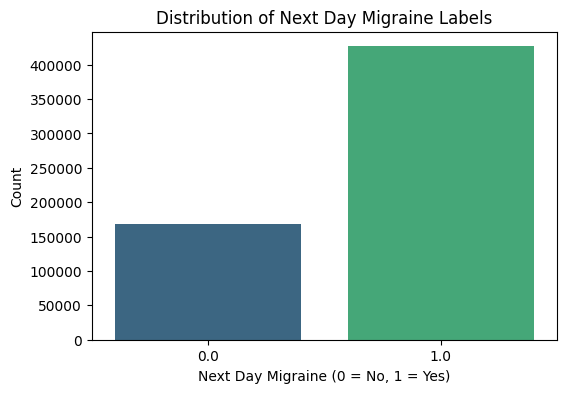

In [ ]:
data=df_filtered

#Visualizing the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=data['next_day_migraine'], palette='viridis')
plt.title('Distribution of Next Day Migraine Labels')
plt.xlabel('Next Day Migraine (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [ ]:
non_null_counts = data.notnull().sum()
baseline_value = non_null_counts['next_day_migraine'] if 'next_day_migraine' in non_null_counts else 0
non_null_percentage = (non_null_counts / baseline_value) * 100 if baseline_value != 0 else non_null_counts * 0

In [ ]:
threshold_percentage = 20

In [ ]:
columns_to_keep = non_null_percentage[non_null_percentage >= threshold_percentage].index.tolist()

In [ ]:
data = data[columns_to_keep]

In [ ]:
pd.set_option('display.max_rows', None)
non_null_counts = {col: data[col].notnull().sum() for col in data.columns}
non_null_df = pd.DataFrame(list(non_null_counts.items()), columns=['Column', 'Non-Null Count'])
print(non_null_df)

                                     Column  Non-Null Count
0                                   user_id          594117
1                                    gender          594112
2                                       age          594112
3                                      date          594117
4                         next_day_migraine          594117
5                              migraine_day          176425
6                                pain_level          179646
7                           nausea_vomiting          164675
8                            neck_stiffness          164675
9                      sensitivity_to_light          164675
10                     sensitivity_to_sound          164675
11                     dizziness_or_vertigo          164675
12                                     aura          165605
13                    functional_disability          168005
14                          day_of_the_week          594117
15                 last_migraine_pain_le

In [ ]:
# test model (dataset size based split and estimation)

In [ ]:
data_for_dummies_test = data
data_for_dummies_test = data_for_dummies_test.drop(columns=['user_id', 'date'])

data_for_dummies_test = pd.get_dummies(data_for_dummies_test, drop_first=True)

In [ ]:
X = data_for_dummies_test.drop(columns=['next_day_migraine'])
y = data_for_dummies_test['next_day_migraine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

precision, recall, accuracy, specificity, conf_matrix

(0.8655186914853589,
 0.9153684999005162,
 0.836876388608362,
 0.6359823862444957,
 array([[21231, 12152],
        [ 7231, 78210]]))

In [ ]:
# test model (user based split and estimation)

In [ ]:
data_for_dummies_test = data.copy()

data_for_dummies_test = data_for_dummies_test.drop(columns=['date'])

categorical_columns = ['gender', 'prevention_treatments']

data_for_dummies_test = pd.get_dummies(data_for_dummies_test, columns=categorical_columns, drop_first=True)

users = data_for_dummies_test['user_id'].unique()
train_users, test_users = train_test_split(users, test_size=0.2, random_state=42)
train_users, val_users = train_test_split(train_users, test_size=0.2, random_state=42)

train_data = data_for_dummies_test[data_for_dummies_test['user_id'].isin(train_users)]
val_data = data_for_dummies_test[data_for_dummies_test['user_id'].isin(val_users)]
test_data = data_for_dummies_test[data_for_dummies_test['user_id'].isin(test_users)]

train_data = train_data.drop(columns=['user_id'])
val_data = val_data.drop(columns=['user_id'])
test_data = test_data.drop(columns=['user_id'])

X_train, y_train = train_data.drop(columns=['next_day_migraine']), train_data['next_day_migraine']
X_val, y_val = val_data.drop(columns=['next_day_migraine']), val_data['next_day_migraine']
X_test, y_test = test_data.drop(columns=['next_day_migraine']), test_data['next_day_migraine']

model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

conf_matrix_overall = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix_overall.ravel()
overall_precision = precision_score(y_test, y_pred, zero_division=0)
overall_recall = recall_score(y_test, y_pred, zero_division=0)
overall_accuracy = (tp + tn) / (tp + tn + fp + fn)
overall_specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

In [ ]:

print("\nDataset-based Metrics:")
print(f"Precision: {overall_precision:.4f}, Recall: {overall_recall:.4f}, Accuracy: {overall_accuracy:.4f}, Specificity: {overall_specificity:.4f}")



Dataset-based Metrics:
Precision: 0.8678, Recall: 0.9152, Accuracy: 0.8358, Specificity: 0.6189


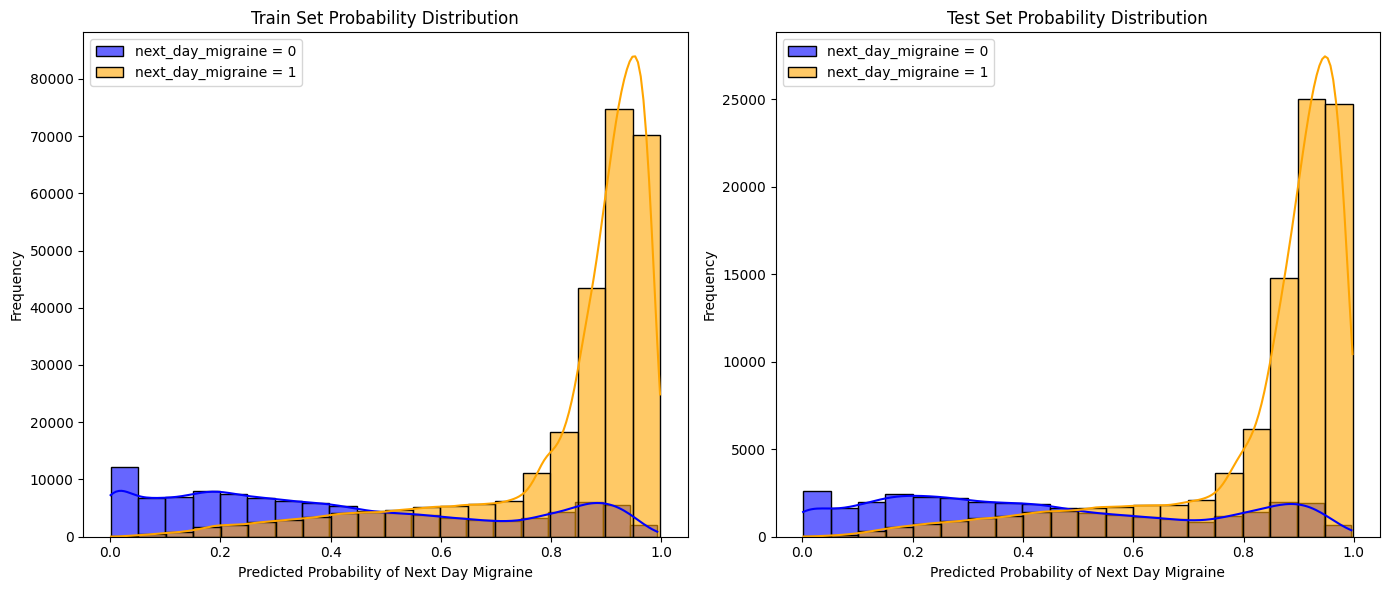

In [ ]:
train_pred_proba = model.predict_proba(X_train)[:, 1]
test_pred_proba = model.predict_proba(X_test)[:, 1]

train_df = pd.DataFrame({'next_day_migraine': y_train, 'predicted_proba': train_pred_proba})
test_df = pd.DataFrame({'next_day_migraine': y_test, 'predicted_proba': test_pred_proba})

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=train_df[train_df['next_day_migraine'] == 0], x='predicted_proba', color='blue', label='next_day_migraine = 0', kde=True, bins=20, alpha=0.6)
sns.histplot(data=train_df[train_df['next_day_migraine'] == 1], x='predicted_proba', color='orange', label='next_day_migraine = 1', kde=True, bins=20, alpha=0.6)
plt.title("Train Set Probability Distribution")
plt.xlabel("Predicted Probability of Next Day Migraine")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=test_df[test_df['next_day_migraine'] == 0], x='predicted_proba', color='blue', label='next_day_migraine = 0', kde=True, bins=20, alpha=0.6)
sns.histplot(data=test_df[test_df['next_day_migraine'] == 1], x='predicted_proba', color='orange', label='next_day_migraine = 1', kde=True, bins=20, alpha=0.6)
plt.title("Test Set Probability Distribution")
plt.xlabel("Predicted Probability of Next Day Migraine")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

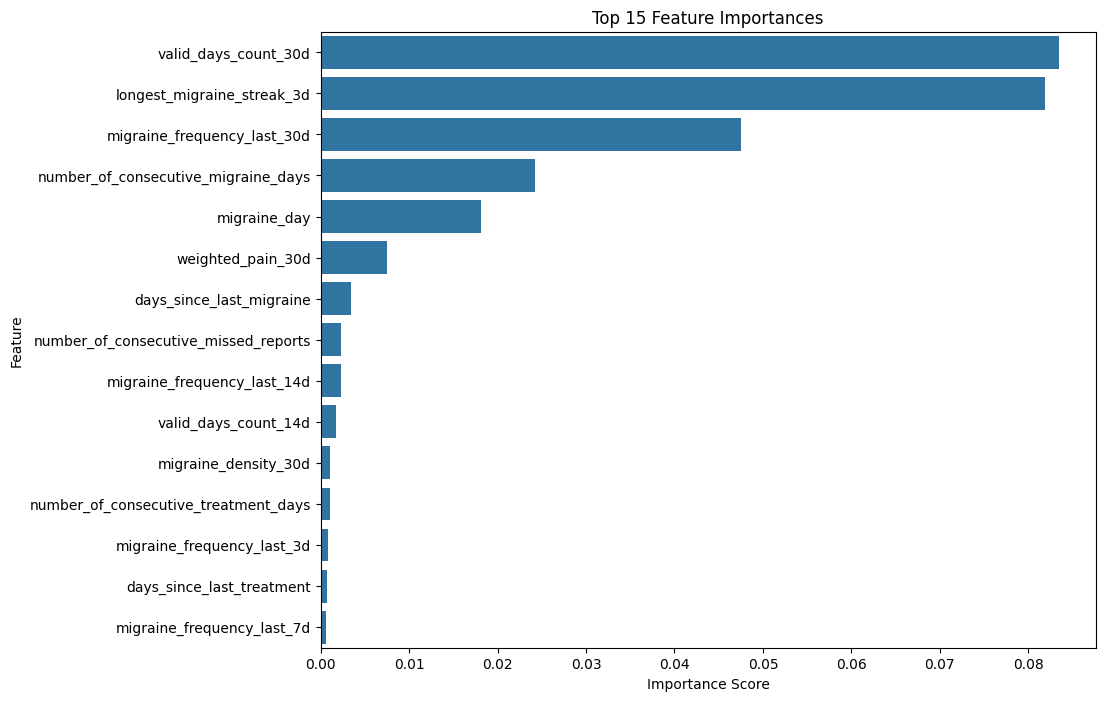

In [ ]:
model.fit(X_train, y_train)

result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)

feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

# Plot the top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df.head(15))
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

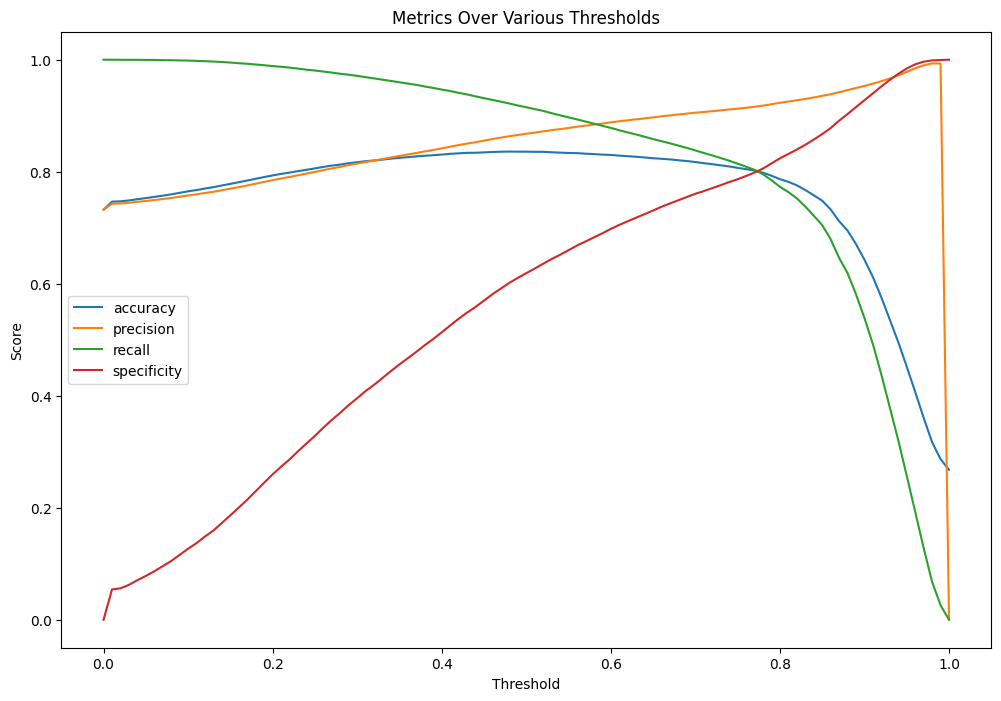

In [ ]:
# Model Evaluation
thresholds = np.linspace(0, 1, 101)

metrics_over_thresholds = {
    'threshold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'specificity': []
}

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    metrics_over_thresholds['threshold'].append(threshold)
    metrics_over_thresholds['accuracy'].append(accuracy_score(y_test, y_pred_thresh))
    metrics_over_thresholds['precision'].append(precision_score(y_test, y_pred_thresh, zero_division=0))
    metrics_over_thresholds['recall'].append(recall_score(y_test, y_pred_thresh, zero_division=0))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics_over_thresholds['specificity'].append(specificity)

metrics_over_thresholds_df = pd.DataFrame(metrics_over_thresholds)

plt.figure(figsize=(12, 8))
for metric in ['accuracy', 'precision', 'recall', 'specificity']:
    plt.plot(metrics_over_thresholds_df['threshold'], metrics_over_thresholds_df[metric], label=metric)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics Over Various Thresholds")
plt.legend()
plt.show()

In [ ]:
# user based split + weighted classes

categorical_columns = ['gender','prevention_treatments']

# Label encode categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

data['date'] = pd.to_datetime(data['date'])

# Calculate user activity statistics
user_stats = data.groupby('user_id').agg(
    total_samples=('date', 'count'),
    min_date=('date', 'min'),
    max_date=('date', 'max')
)
user_stats['active_days'] = (user_stats['max_date'] - user_stats['min_date']).dt.days + 1

# 1. Remove very sparse users (1-3 samples in 10-20 days)
sparse_users = user_stats[
    (user_stats['active_days'] >= 10) & (user_stats['active_days'] <= 20) & (user_stats['total_samples'] <= 3)
].index

# 2. Remove users with very short history (fewer than 3-5 samples)
short_history_users = user_stats[user_stats['total_samples'] < 5].index

# Combine filters and remove users
filtered_users = user_stats.index.difference(sparse_users.union(short_history_users))
data_filtered = data[data['user_id'].isin(filtered_users)]

# Print user counts
original_user_count = len(user_stats)
sparse_user_count = len(sparse_users)
short_history_user_count = len(short_history_users)
filtered_user_count = len(filtered_users)
removed_user_count = original_user_count - filtered_user_count

print(f"Original number of users: {original_user_count}")
print(f"Number of very sparse users removed: {sparse_user_count}")
print(f"Number of short history users removed: {short_history_user_count}")
print(f"Number of users remaining after filtering: {filtered_user_count}")
print(f"Total number of users removed: {removed_user_count}")

# User-based train-test-validation split
unique_users = data_filtered['user_id'].unique()
train_users, temp_users = train_test_split(unique_users, test_size=0.4, random_state=42)
val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=42)

train_data = data_filtered[data_filtered['user_id'].isin(train_users)]
val_data = data_filtered[data_filtered['user_id'].isin(val_users)]
test_data = data_filtered[data_filtered['user_id'].isin(test_users)]

# Prepare features and target variables
X_train = train_data.drop(columns=['next_day_migraine', 'user_id', 'date'], errors='ignore')
y_train = train_data['next_day_migraine']

X_val = val_data.drop(columns=['next_day_migraine', 'user_id', 'date'], errors='ignore')
y_val = val_data['next_day_migraine']

X_test = test_data.drop(columns=['next_day_migraine', 'user_id', 'date'], errors='ignore')
y_test = test_data['next_day_migraine']

X_train = X_train.select_dtypes(include=[int, float, bool])
X_val = X_val.select_dtypes(include=[int, float, bool])
X_test = X_test.select_dtypes(include=[int, float, bool])

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Calculate class weights
class_weights = y_train.value_counts(normalize=True).to_dict()
class_weights = {key: 1 / value for key, value in class_weights.items()}

# Function to calculate specificity
def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Train XGBoost Model
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42,
    'use_label_encoder': False,
    'scale_pos_weight': class_weights[1] / class_weights[0]  # Apply class weights
}

evals = [(dtrain, 'train'), (dval, 'validation')]
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

xgb_preds = xgb_model.predict(dtest)
xgb_pred_labels = (xgb_preds > 0.5).astype(int)
xgb_auc = roc_auc_score(y_test, xgb_preds)
xgb_accuracy = accuracy_score(y_test, xgb_pred_labels)
xgb_specificity = calculate_specificity(y_test, xgb_pred_labels)
xgb_recall = recall_score(y_test, xgb_pred_labels)
xgb_precision = precision_score(y_test, xgb_pred_labels)
xgb_conf_matrix = confusion_matrix(y_test, xgb_pred_labels)

print("=== XGBoost Results ===")
print(f"AUC: {xgb_auc:.4f}")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Specificity: {xgb_specificity:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print("Confusion Matrix:")
print(xgb_conf_matrix)
print(classification_report(y_test, xgb_pred_labels))

# Train LightGBM Model
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight=class_weights)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=1)]
)
lgb_preds = lgb_model.predict_proba(X_test)[:, 1]
lgb_pred_labels = (lgb_preds > 0.5).astype(int)
lgb_auc = roc_auc_score(y_test, lgb_preds)
lgb_accuracy = accuracy_score(y_test, lgb_pred_labels)
lgb_specificity = calculate_specificity(y_test, lgb_pred_labels)
lgb_recall = recall_score(y_test, lgb_pred_labels)
lgb_precision = precision_score(y_test, lgb_pred_labels)
lgb_conf_matrix = confusion_matrix(y_test, lgb_pred_labels)
print("\n=== LightGBM Results ===")
print(f"AUC: {lgb_auc:.4f}")
print(f"Accuracy: {lgb_accuracy:.4f}")
print(f"Specificity: {lgb_specificity:.4f}")
print(f"Recall: {lgb_recall:.4f}")
print(f"Precision: {lgb_precision:.4f}")
print("Confusion Matrix:")
print(lgb_conf_matrix)
print(classification_report(y_test, lgb_pred_labels))

# Train CatBoost Model
cat_model = CatBoostClassifier(
    verbose=0,  # Suppress training output
    random_state=42,
    class_weights=[class_weights[0], class_weights[1]]  # Apply class weights
)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10)
cat_preds = cat_model.predict_proba(X_test)[:, 1]
cat_pred_labels = (cat_preds > 0.5).astype(int)
cat_auc = roc_auc_score(y_test, cat_preds)
cat_accuracy = accuracy_score(y_test, cat_pred_labels)
cat_specificity = calculate_specificity(y_test, cat_pred_labels)
cat_recall = recall_score(y_test, cat_pred_labels)
cat_precision = precision_score(y_test, cat_pred_labels)
cat_conf_matrix = confusion_matrix(y_test, cat_pred_labels)

print("\n=== CatBoost Results ===")
print(f"AUC: {cat_auc:.4f}")
print(f"Accuracy: {cat_accuracy:.4f}")
print(f"Specificity: {cat_specificity:.4f}")
print(f"Recall: {cat_recall:.4f}")
print(f"Precision: {cat_precision:.4f}")
print("Confusion Matrix:")
print(cat_conf_matrix)
print(classification_report(y_test, cat_pred_labels))


/var/tmp/ipykernel_10384/2121460876.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = le.fit_transform(data[col])
/var/tmp/ipykernel_10384/2121460876.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = le.fit_transform(data[col])
/var/tmp/ipykernel_10384/2121460876.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Original number of users: 47705
Number of very sparse users removed: 1911
Number of short history users removed: 22958
Number of users remaining after filtering: 24747
Total number of users removed: 22958


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:04:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.84082	validation-auc:0.84463
[1]	train-auc:0.85020	validation-auc:0.85343
[2]	train-auc:0.85321	validation-auc:0.85715
[3]	train-auc:0.85606	validation-auc:0.86001
[4]	train-auc:0.85932	validation-auc:0.86305
[5]	train-auc:0.86141	validation-auc:0.86512
[6]	train-auc:0.86408	validation-auc:0.86731
[7]	train-auc:0.86617	validation-auc:0.86922
[8]	train-auc:0.86815	validation-auc:0.87104
[9]	train-auc:0.87146	validation-auc:0.87409
[10]	train-auc:0.87313	validation-auc:0.87582
[11]	train-auc:0.87428	validation-auc:0.87702
[12]	train-auc:0.87517	validation-auc:0.87775
[13]	train-auc:0.87605	validation-auc:0.87853
[14]	train-auc:0.87701	validation-auc:0.87943
[15]	train-auc:0.87746	validation-auc:0.87980
[16]	train-auc:0.87849	validation-auc:0.88052
[17]	train-auc:0.87908	validation-auc:0.88111
[18]	train-auc:0.87990	validation-auc:0.88168
[19]	train-auc:0.88053	validation-auc:0.88220
[20]	train-auc:0.88133	validation-auc:0.88272
[21]	train-auc:0.88158	validation-auc:0.8828

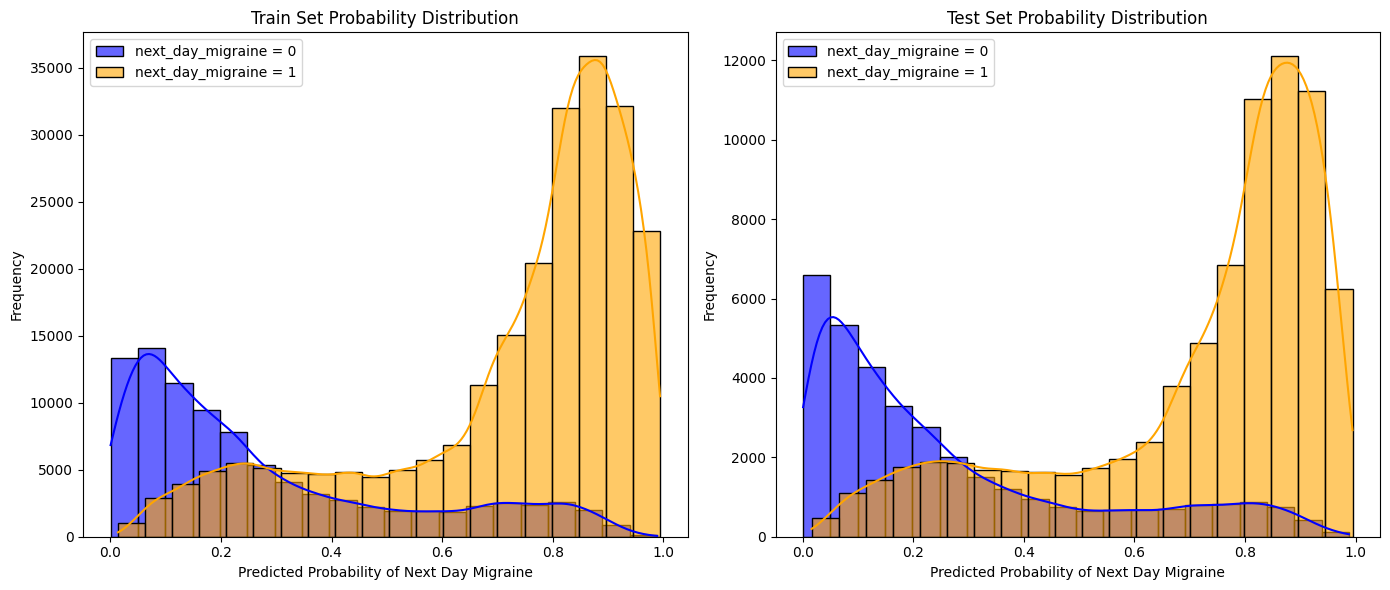

In [ ]:
train_pred_proba = lgb_model.predict_proba(X_train)[:, 1]
test_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

train_df = pd.DataFrame({'next_day_migraine': y_train, 'predicted_proba': train_pred_proba})
test_df = pd.DataFrame({'next_day_migraine': y_test, 'predicted_proba': test_pred_proba})

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=train_df[train_df['next_day_migraine'] == 0], x='predicted_proba', color='blue', label='next_day_migraine = 0', kde=True, bins=20, alpha=0.6)
sns.histplot(data=train_df[train_df['next_day_migraine'] == 1], x='predicted_proba', color='orange', label='next_day_migraine = 1', kde=True, bins=20, alpha=0.6)
plt.title("Train Set Probability Distribution")
plt.xlabel("Predicted Probability of Next Day Migraine")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=test_df[test_df['next_day_migraine'] == 0], x='predicted_proba', color='blue', label='next_day_migraine = 0', kde=True, bins=20, alpha=0.6)
sns.histplot(data=test_df[test_df['next_day_migraine'] == 1], x='predicted_proba', color='orange', label='next_day_migraine = 1', kde=True, bins=20, alpha=0.6)
plt.title("Test Set Probability Distribution")
plt.xlabel("Predicted Probability of Next Day Migraine")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

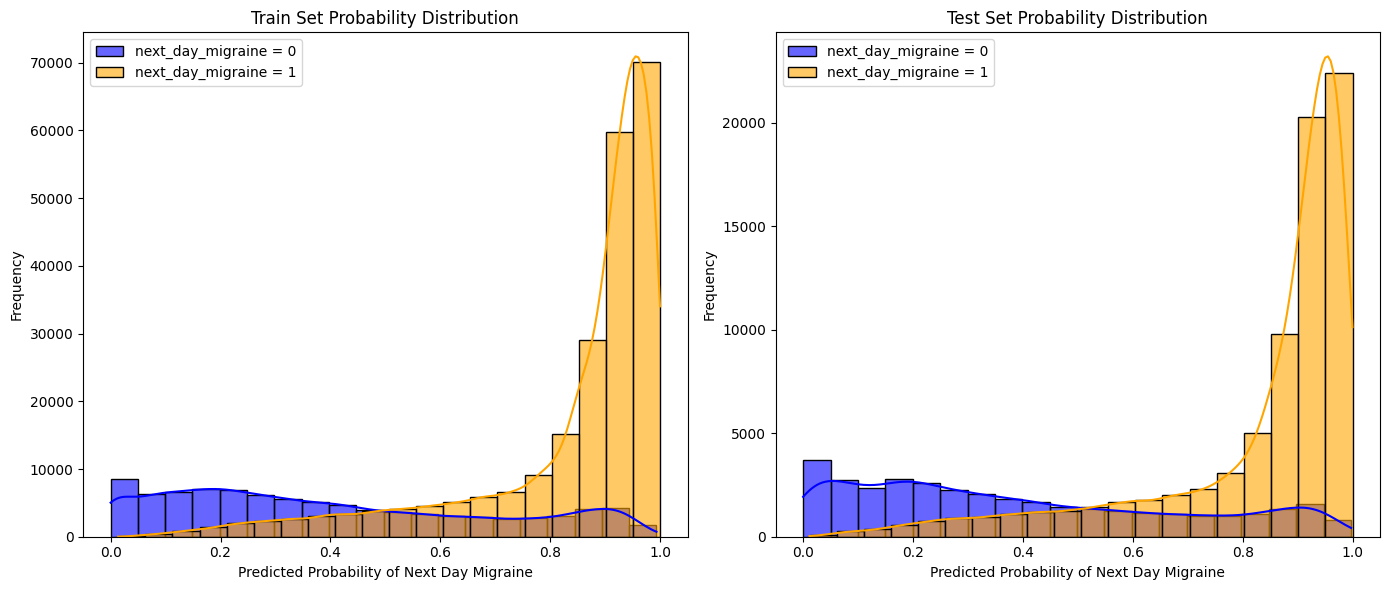

In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]
test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

train_df = pd.DataFrame({'next_day_migraine': y_train, 'predicted_proba': train_pred_proba})
test_df = pd.DataFrame({'next_day_migraine': y_test, 'predicted_proba': test_pred_proba})

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=train_df[train_df['next_day_migraine'] == 0], x='predicted_proba', color='blue', label='next_day_migraine = 0', kde=True, bins=20, alpha=0.6)
sns.histplot(data=train_df[train_df['next_day_migraine'] == 1], x='predicted_proba', color='orange', label='next_day_migraine = 1', kde=True, bins=20, alpha=0.6)
plt.title("Train Set Probability Distribution")
plt.xlabel("Predicted Probability of Next Day Migraine")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=test_df[test_df['next_day_migraine'] == 0], x='predicted_proba', color='blue', label='next_day_migraine = 0', kde=True, bins=20, alpha=0.6)
sns.histplot(data=test_df[test_df['next_day_migraine'] == 1], x='predicted_proba', color='orange', label='next_day_migraine = 1', kde=True, bins=20, alpha=0.6)
plt.title("Test Set Probability Distribution")
plt.xlabel("Predicted Probability of Next Day Migraine")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# XGBOOST

In [ ]:
categorical_columns = ['gender', 'prevention_treatments']

data_with_dummies = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Parse dates for date calculations
data_with_dummies['date'] = pd.to_datetime(data['date'])

user_stats = data_with_dummies.groupby('user_id').agg(
    total_samples=('date', 'count'),
    min_date=('date', 'min'),
    max_date=('date', 'max')
)
user_stats['active_days'] = (user_stats['max_date'] - user_stats['min_date']).dt.days + 1

# Step 1: Remove users with fewer than 5 total records
initial_user_count = data['user_id'].nunique()
initial_record_count = len(data)

filtered_users = user_stats[user_stats['total_samples'] >= 5].index
data_filtered = data_with_dummies[data_with_dummies['user_id'].isin(filtered_users)]

users_removed_step1 = initial_user_count - data_filtered['user_id'].nunique()
records_removed_step1 = initial_record_count - len(data_filtered)

print(f"Step 1: Removed {users_removed_step1} users and {records_removed_step1} records.")

Step 1: Removed 22958 users and 49969 records.


In [ ]:
# Step 2: Rolling x-day window check with x min record check
def filter_sparse_users(df, window_size=20, min_records=3):
    df = df.sort_values(by=['user_id', 'date'])  # Ensure data is sorted

    valid_indices = []
    for user_id, user_data in df.groupby('user_id'):
        dates = user_data['date'].sort_values().to_numpy()
        mask = [False] * len(dates)  # Mask to track valid records

        for i in range(len(dates)):
            start_date = dates[i]
            end_date = start_date + pd.Timedelta(days=window_size)
            count_in_window = ((dates >= start_date) & (dates < end_date)).sum()

            if count_in_window >= min_records:
                mask[i] = True

        valid_indices.extend(user_data.index[mask])  # Store valid indices

    return df.loc[valid_indices]

In [ ]:
before_filtering_users = data_filtered['user_id'].nunique()
before_filtering_records = len(data_filtered)

# Rolling filtering
data_filtered = filter_sparse_users(data_filtered)

users_removed_step2 = before_filtering_users - data_filtered['user_id'].nunique()
records_removed_step2 = before_filtering_records - len(data_filtered)

print(f"Step 2: Removed {users_removed_step2} users and {records_removed_step2} records.")

final_user_count = data_filtered['user_id'].nunique()
final_record_count = len(data_filtered)

print(f"Final dataset contains {final_user_count} users and {final_record_count} records.")

Step 2: Removed 2888 users and 165941 records.
Final dataset contains 21859 users and 378207 records.


[0]	train-auc:0.85115	validation-auc:0.85876
[1]	train-auc:0.85523	validation-auc:0.86163
[2]	train-auc:0.85667	validation-auc:0.86342
[3]	train-auc:0.85876	validation-auc:0.86549
[4]	train-auc:0.86049	validation-auc:0.86820
[5]	train-auc:0.86287	validation-auc:0.87037
[6]	train-auc:0.86514	validation-auc:0.87182
[7]	train-auc:0.86663	validation-auc:0.87297
[8]	train-auc:0.86782	validation-auc:0.87386
[9]	train-auc:0.86921	validation-auc:0.87495
[10]	train-auc:0.87014	validation-auc:0.87586
[11]	train-auc:0.87107	validation-auc:0.87653
[12]	train-auc:0.87236	validation-auc:0.87744
[13]	train-auc:0.87311	validation-auc:0.87809
[14]	train-auc:0.87372	validation-auc:0.87865
[15]	train-auc:0.87459	validation-auc:0.87933
[16]	train-auc:0.87510	validation-auc:0.87968
[17]	train-auc:0.87565	validation-auc:0.88014
[18]	train-auc:0.87632	validation-auc:0.88075
[19]	train-auc:0.87693	validation-auc:0.88122
[20]	train-auc:0.87769	validation-auc:0.88187
[21]	train-auc:0.87861	validation-auc:0.8825

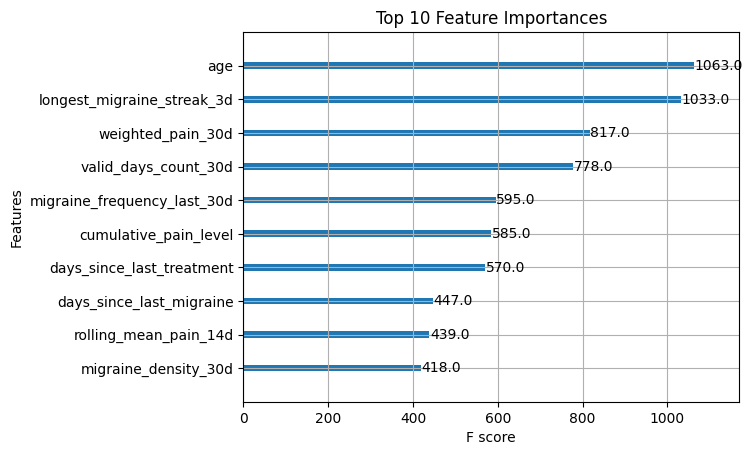

In [ ]:
# User-based train-test-validation split
unique_users = data_filtered['user_id'].unique()
train_users, temp_users = train_test_split(unique_users, test_size=0.4, random_state=42)
val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=42)

train_data = data_filtered[data_filtered['user_id'].isin(train_users)]
val_data = data_filtered[data_filtered['user_id'].isin(val_users)]
test_data = data_filtered[data_filtered['user_id'].isin(test_users)]

X_train = train_data.drop(columns=['next_day_migraine', 'user_id', 'date'], errors='ignore')
y_train = train_data['next_day_migraine']

X_val = val_data.drop(columns=['next_day_migraine', 'user_id', 'date'], errors='ignore')
y_val = val_data['next_day_migraine']

X_test = test_data.drop(columns=['next_day_migraine', 'user_id', 'date'], errors='ignore')
y_test = test_data['next_day_migraine']

X_train = X_train.select_dtypes(include=[int, float, bool])
X_val = X_val.select_dtypes(include=[int, float, bool])
X_test = X_test.select_dtypes(include=[int, float, bool])

# Calculate class weights
class_weights = y_train.value_counts(normalize=True).to_dict()
class_weights = {key: 1 / value for key, value in class_weights.items()}
scale_pos_weight = class_weights[1] / class_weights[0]

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight,
    'eta': 0.1,  # Learning rate
    'max_depth': 6,  # Depth of trees
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'lambda': 1,  # L2 regularization term
    'alpha': 0.5  # L1 regularization term
}


# Train XGBoost Model
evals = [(dtrain, 'train'), (dval, 'validation')]
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

# Predictions and Evaluation
xgb_preds = xgb_model.predict(dtest)
xgb_pred_labels = (xgb_preds > 0.5).astype(int)

# Metrics
xgb_auc = roc_auc_score(y_test, xgb_preds)
xgb_accuracy = accuracy_score(y_test, xgb_pred_labels)
xgb_recall = recall_score(y_test, xgb_pred_labels)
xgb_precision = precision_score(y_test, xgb_pred_labels)
xgb_specificity = calculate_specificity(y_test, xgb_pred_labels)
xgb_f1 = f1_score(y_test, xgb_pred_labels)

# Confusion Matrix and Classification Report
xgb_conf_matrix = confusion_matrix(y_test, xgb_pred_labels)
print("=== XGBoost Results ===")
print(f"AUC: {xgb_auc:.4f}")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Specificity: {xgb_specificity:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print("Confusion Matrix:")
print(xgb_conf_matrix)
print(classification_report(y_test, xgb_pred_labels))

# Plot Feature Importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


In [ ]:
feature_names = data_filtered.drop(columns=['next_day_migraine']).columns.tolist()
print(feature_names)

['user_id', 'age', 'date', 'migraine_day', 'pain_level', 'nausea_vomiting', 'neck_stiffness', 'sensitivity_to_light', 'sensitivity_to_sound', 'dizziness_or_vertigo', 'aura', 'functional_disability', 'day_of_the_week', 'last_migraine_pain_level', 'days_since_last_migraine', 'number_of_consecutive_migraine_days', 'number_of_consecutive_non_migraine_days', 'number_of_consecutive_missed_reports', 'number_of_consecutive_treatment_days', 'days_since_last_treatment', 'valid_days_count_3d', 'migraine_frequency_last_3d', 'valid_days_count_14d', 'migraine_frequency_last_14d', 'valid_days_count_30d', 'migraine_frequency_last_30d', 'valid_days_count_7d', 'migraine_frequency_last_7d', 'rolling_mean_pain_3d', 'rolling_mean_pain_7d', 'rolling_mean_pain_14d', 'rolling_max_pain_3d', 'rolling_max_pain_7d', 'rolling_max_pain_14d', 'migraine_density_3d', 'weighted_pain_3d', 'longest_migraine_streak_3d', 'occurrence_acceleration_3d', 'migraine_density_7d', 'weighted_pain_7d', 'longest_migraine_streak_7d', 

In [ ]:
rolling_mean_features = ['rolling_mean_pain_14d', 'rolling_mean_pain_3d', 'rolling_mean_pain_7d']

rolling_max_features = ['rolling_max_pain_14d', 'rolling_max_pain_3d', 'rolling_max_pain_7d']

frequency_features = ['migraine_frequency_last_30d', 'migraine_frequency_last_3d', 'migraine_frequency_last_7d', 'migraine_frequency_last_14d']

baseline = ['age', 'gender_MALE', 'gender_UNDEFINED', 'gender_FEMALE']

symptom_features = ['pain_level',
    'nausea_vomiting', 'food_cravings',
    'neck_stiffness', 'difficulties_on_speaking_reading_writing', 'fatigue', 'irritability',
    'frequent_urination', 'yawning', 'sensitivity_to_light', 'sensitivity_to_sound',
    'mood_changes', 'dizziness_or_vertigo', 'sensitivity_to_odors', 'headache_lasting_time',
    'aura', 'functional_disability', 'menstruation_day', 'symptoms_started_occur'
]

calculated_features = ['migraine_day', 'absenteeism','prevention_treatments_Yes', 'prevention_treatments_No', 'days_since_last_treatment','number_of_consecutive_migraine_days', 'number_of_consecutive_non_migraine_days', 'number_of_consecutive_missed_reports', 'number_of_consecutive_treatment_days', 'day_of_the_week' , 'days_since_last_migraine']

density_features= ['occurrence_acceleration_3d', 'longest_migraine_streak_3d', 'migraine_density_7d', 'occurrence_acceleration_7d',
                  'longest_migraine_streak_7d', 'migraine_density_14d', 'occurrence_acceleration_14d', 'longest_migraine_streak_14d',
                  'migraine_density_30d', 'occurrence_acceleration_30d', 'longest_migraine_streak_30d']

cumulative_features = ['cumulative_pain_level']

lag_features = ['pain_level_lag_1', 'pain_level_lag_2', 'pain_level_lag_3']

medication_features = [
    'over_the_counter_not_helpful', 'over_the_counter_helpful', 'triptan_not_helpful',
    'triptan_helpful', 'nurtec_not_helpful', 'nurtec_helpful', 'ubrelvy_not_helpful',
    'ubrelvy_helpful', 'nasal_injectable_not_helpful', 'nasal_injectable_helpful',
    'reyvow_not_helpful', 'reyvow_helpful', 'nerivio_not_helpful', 'nerivio_helpful',
    'other_devices_not_helpful', 'other_devices_helpful', 'medication_for_nausea_not_helpful',
    'medication_for_nausea_helpful', 'other_medications_not_helpful', 'other_medications_helpful',
    'diclofenac_potassium_not_helpful', 'diclofenac_potassium_helpful', 'triptan_combination_not_helpful',
    'triptan_combination_helpful', 'nasal_spray_not_helpful', 'nasal_spray_helpful', 'injections_not_helpful',
    'injections_helpful', 'zavzpret_nasal_spray_not_helpful', 'zavzpret_nasal_spray_helpful'
]

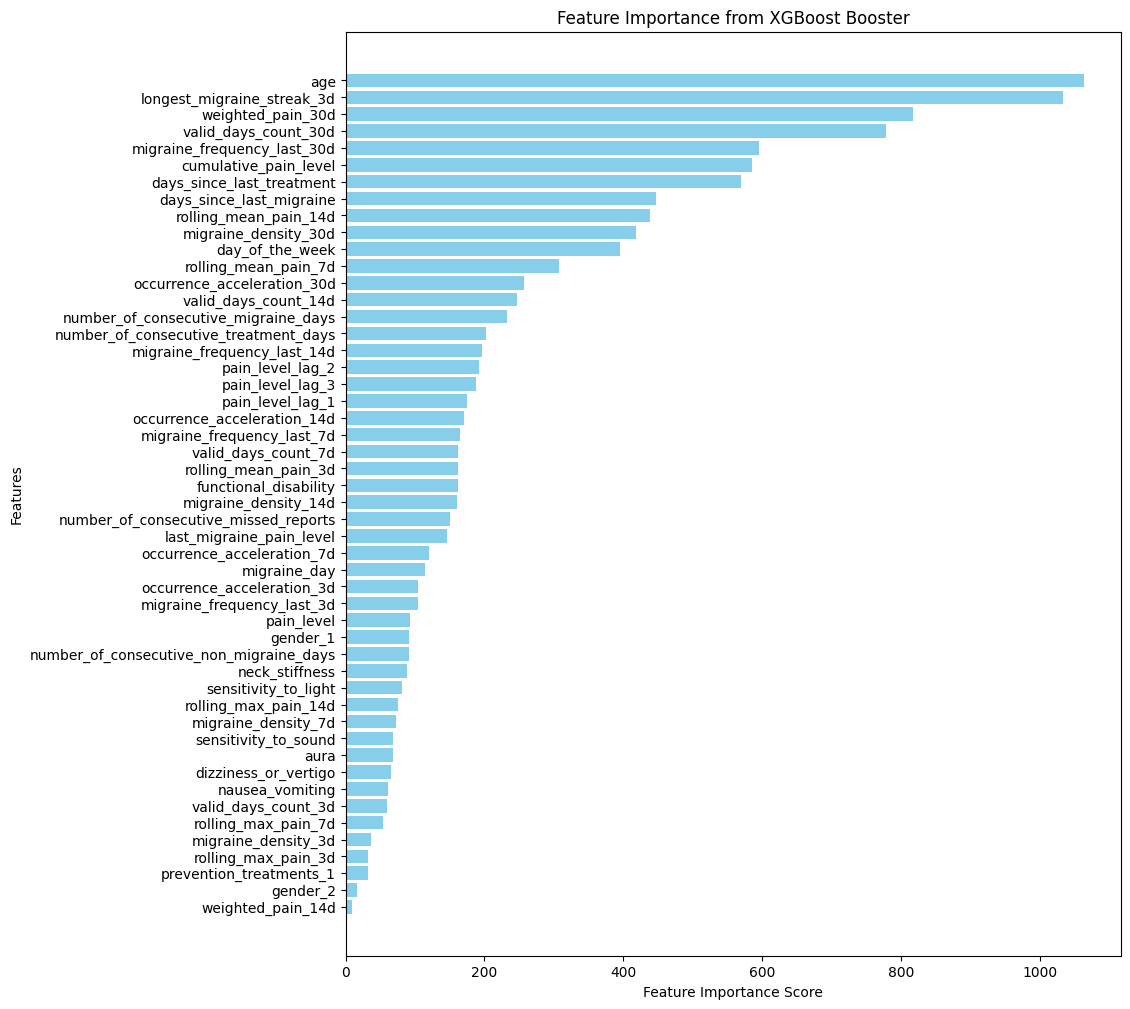

Sorted Feature Importance:
                                    Feature  Importance
0                                       age      1063.0
33               longest_migraine_streak_3d      1033.0
41                        weighted_pain_30d       817.0
22                     valid_days_count_30d       778.0
23              migraine_frequency_last_30d       595.0
46                    cumulative_pain_level       585.0
17                days_since_last_treatment       570.0
12                 days_since_last_migraine       447.0
28                    rolling_mean_pain_14d       439.0
40                     migraine_density_30d       418.0
10                          day_of_the_week       395.0
27                     rolling_mean_pain_7d       308.0
42              occurrence_acceleration_30d       257.0
20                     valid_days_count_14d       247.0
13      number_of_consecutive_migraine_days       232.0
16     number_of_consecutive_treatment_days       202.0
21              migra

In [ ]:
feature_importance = xgb_model.get_score(importance_type='weight')

# Convert to DataFrame for easier handling
importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from XGBoost Booster")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

# Print sorted feature importance
print("Sorted Feature Importance:")
print(importance_df)


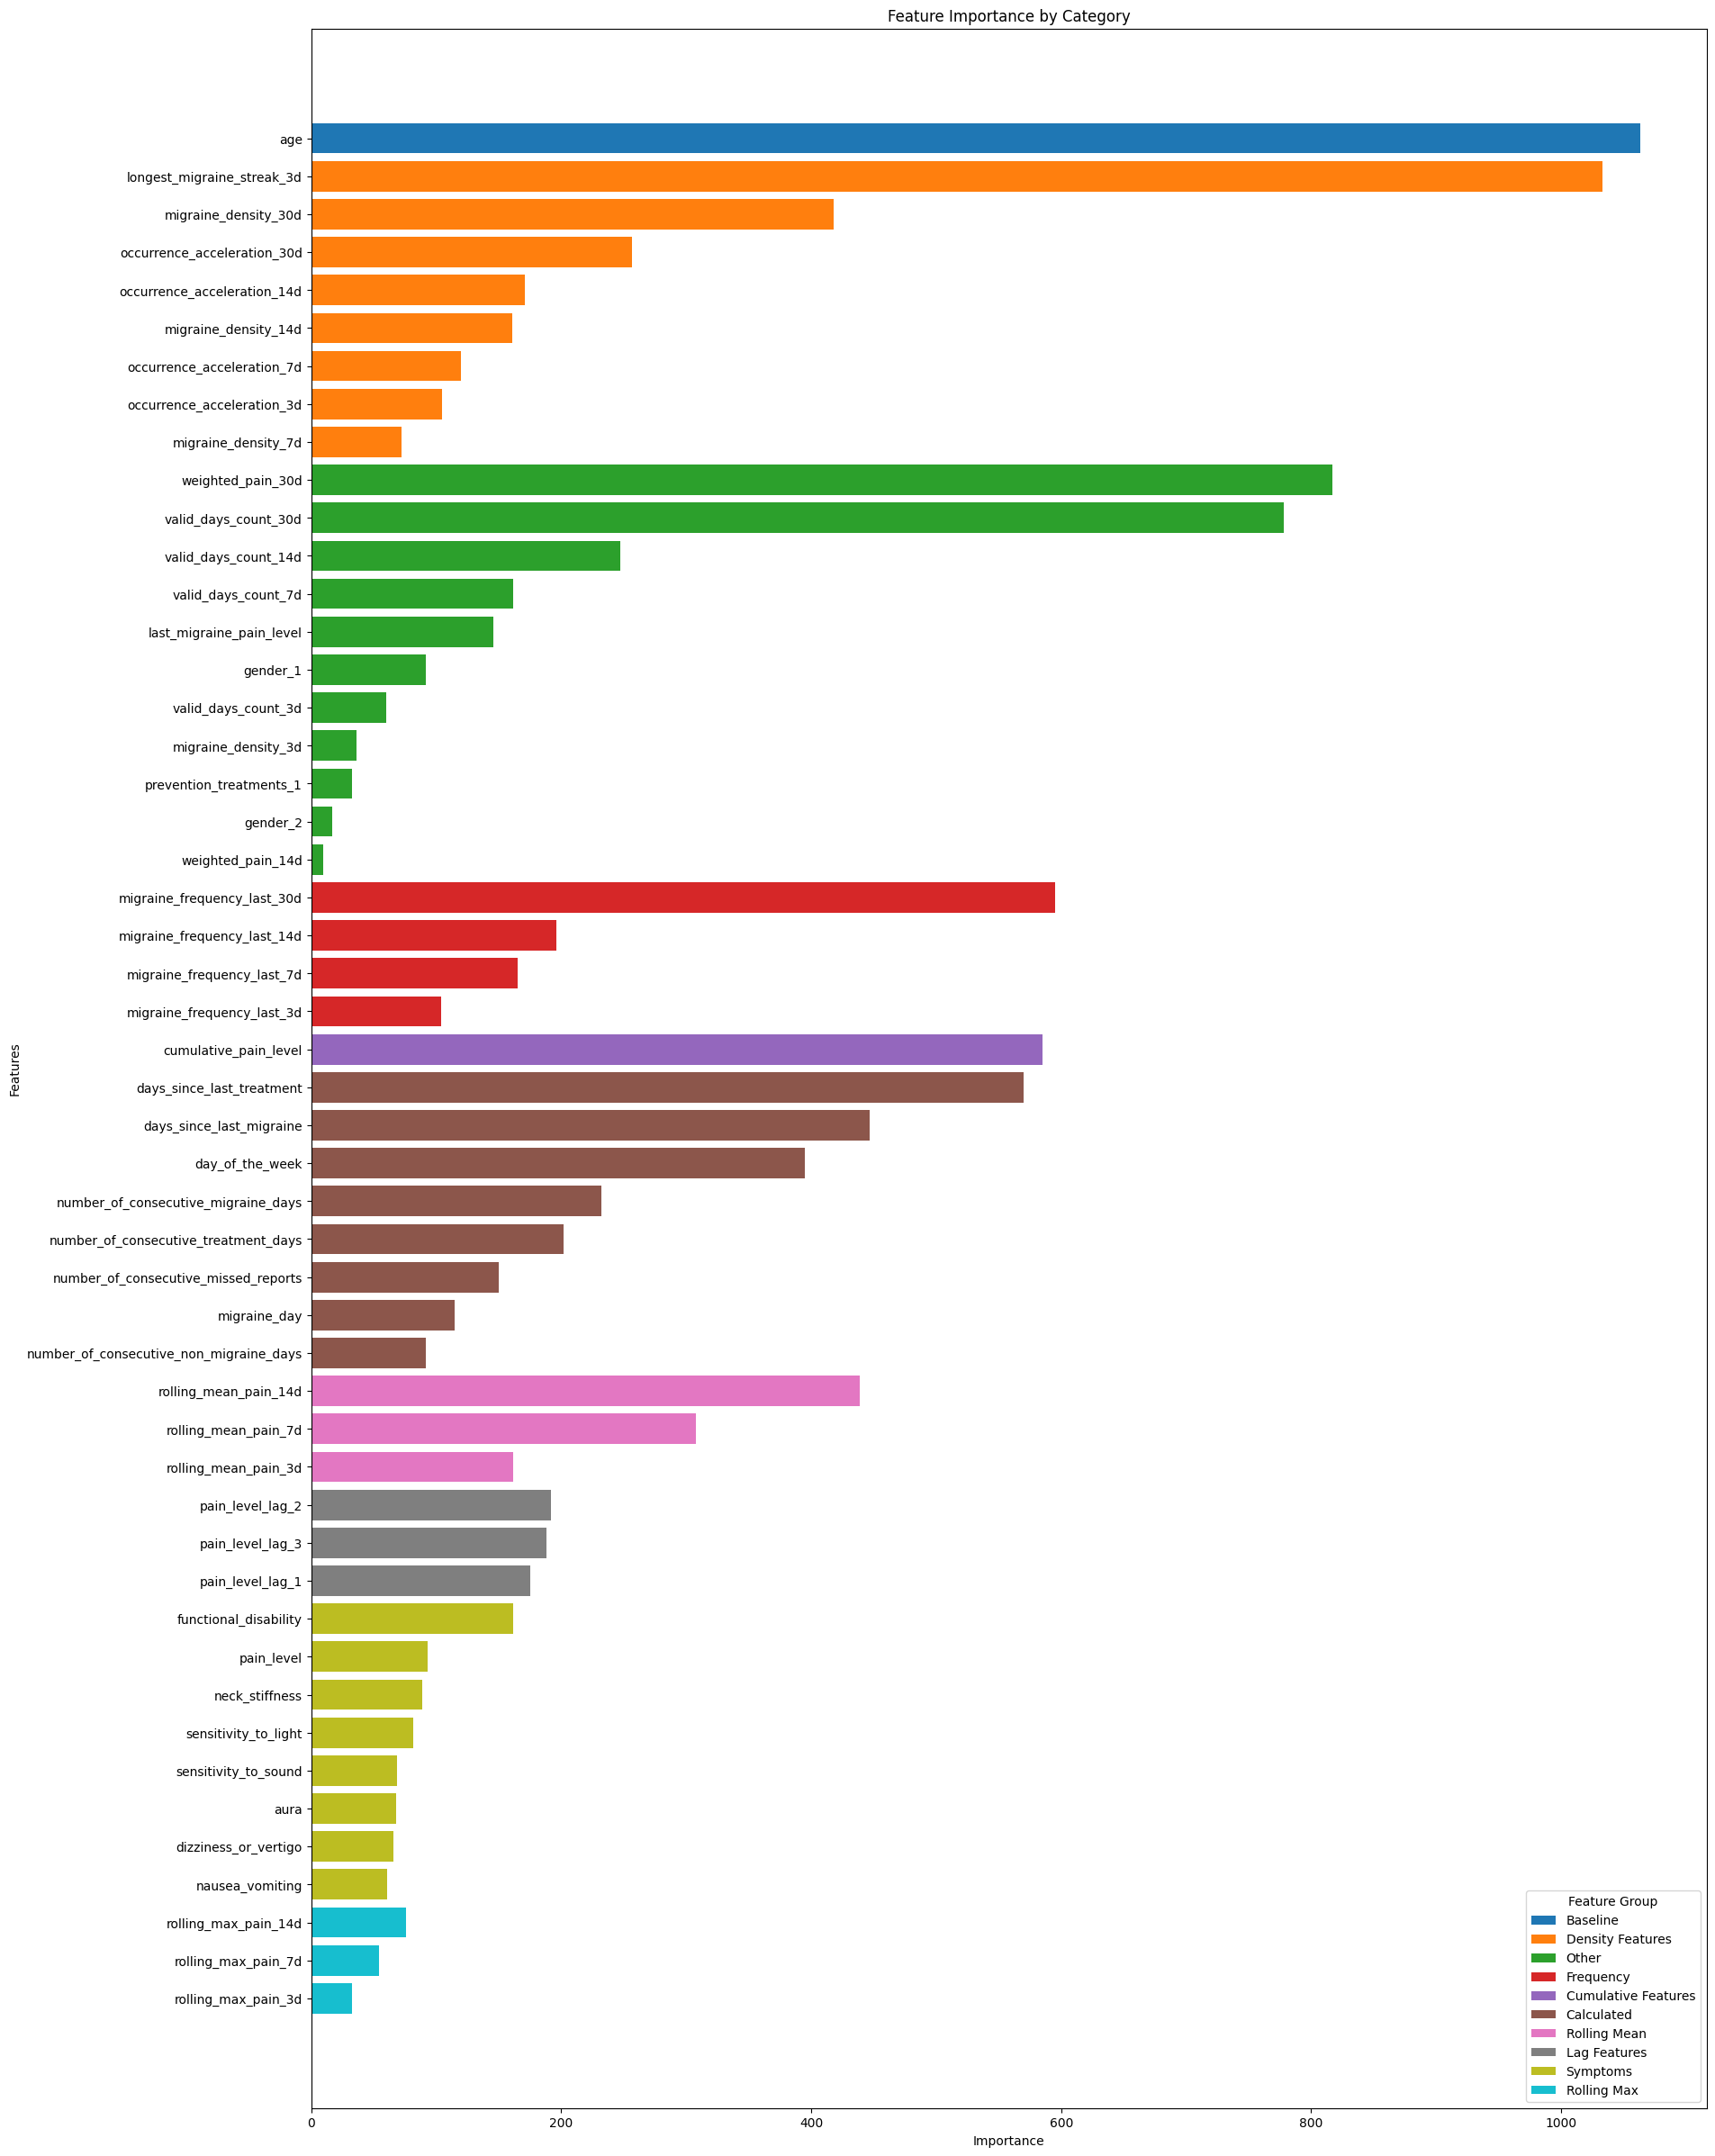

In [ ]:
def assign_group(feature):
    if feature in rolling_mean_features:
        return 'Rolling Mean'
    elif feature in rolling_max_features:
        return 'Rolling Max'
    elif feature in frequency_features:
        return 'Frequency'
    elif feature in symptom_features:
        return 'Symptoms'
    elif feature in medication_features:
        return 'Medications'
    elif feature in calculated_features:
        return 'Calculated'
    elif feature in baseline:
        return 'Baseline'
    elif feature in density_features:
        return 'Density Features'
    elif feature in cumulative_features:
        return 'Cumulative Features'
    elif feature in lag_features:
        return 'Lag Features'
    else:
        return 'Other'

importance_df['Group'] = importance_df['Feature'].apply(assign_group)

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 30))
for group in importance_df['Group'].unique():
    subset = importance_df[importance_df['Group'] == group]
    plt.barh(subset['Feature'], subset['Importance'], label=group)

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Category')
plt.legend(title='Feature Group')
plt.gca().invert_yaxis()
plt.show()

[0]	train-auc:0.85115	validation-auc:0.85876
[1]	train-auc:0.85523	validation-auc:0.86163
[2]	train-auc:0.85667	validation-auc:0.86342
[3]	train-auc:0.85876	validation-auc:0.86549
[4]	train-auc:0.86049	validation-auc:0.86820
[5]	train-auc:0.86287	validation-auc:0.87037
[6]	train-auc:0.86514	validation-auc:0.87182
[7]	train-auc:0.86663	validation-auc:0.87297
[8]	train-auc:0.86782	validation-auc:0.87386
[9]	train-auc:0.86921	validation-auc:0.87495
[10]	train-auc:0.87014	validation-auc:0.87586
[11]	train-auc:0.87107	validation-auc:0.87653
[12]	train-auc:0.87236	validation-auc:0.87744
[13]	train-auc:0.87311	validation-auc:0.87809
[14]	train-auc:0.87372	validation-auc:0.87865
[15]	train-auc:0.87459	validation-auc:0.87933
[16]	train-auc:0.87510	validation-auc:0.87968
[17]	train-auc:0.87565	validation-auc:0.88014
[18]	train-auc:0.87632	validation-auc:0.88075
[19]	train-auc:0.87693	validation-auc:0.88122
[20]	train-auc:0.87769	validation-auc:0.88187
[21]	train-auc:0.87861	validation-auc:0.8825

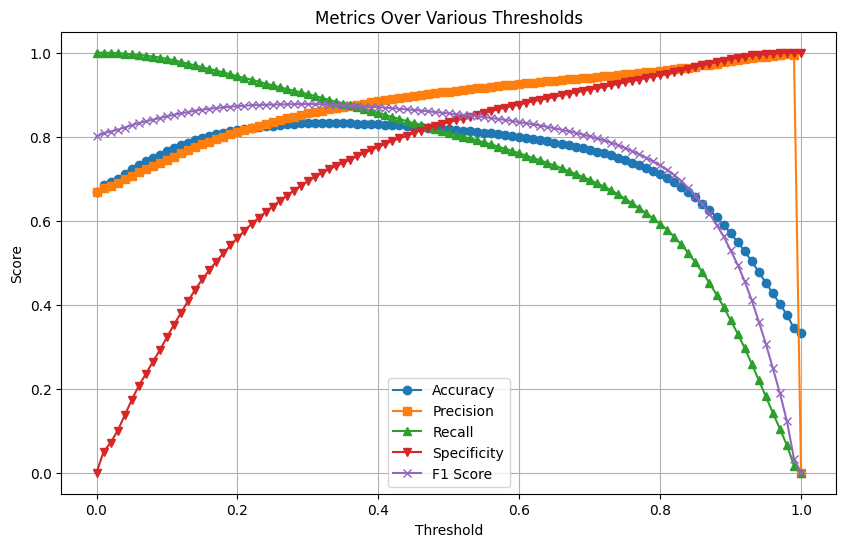

In [ ]:
# Train XGBoost Model
evals = [(dtrain, 'train'), (dval, 'validation')]
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

# Predictions (probabilities)
xgb_preds = xgb_model.predict(dtest)

# Set a specific threshold value
threshold = 0.48

# Generate predictions using the chosen threshold
xgb_pred_labels = (xgb_preds >= threshold).astype(int)

# Compute metrics at the chosen threshold
xgb_auc = roc_auc_score(y_test, xgb_preds)
xgb_accuracy = accuracy_score(y_test, xgb_pred_labels)
xgb_recall = recall_score(y_test, xgb_pred_labels)
xgb_precision = precision_score(y_test, xgb_pred_labels)
tn, fp, fn, tp = confusion_matrix(y_test, xgb_pred_labels).ravel()
xgb_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
xgb_f1 = f1_score(y_test, xgb_pred_labels)

# Print metrics at threshold 0.66
print(f"Metrics at threshold {threshold}:")
print(f"AUC: {xgb_auc:.4f}")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"Specificity: {xgb_specificity:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")

# Evaluate Metrics Over Multiple Thresholds (0 to 1 in 101 steps)
thresholds = np.linspace(0, 1, 101)
metrics_over_thresholds = {
    'threshold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'specificity': [],
    'f1_score': [],
    'false_positive_rate': []
}

# Loop through thresholds to calculate metrics
for th in thresholds:
    y_pred_thresh = (xgb_preds >= th).astype(int)

    accuracy = accuracy_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    metrics_over_thresholds['threshold'].append(th)
    metrics_over_thresholds['accuracy'].append(accuracy)
    metrics_over_thresholds['precision'].append(precision)
    metrics_over_thresholds['recall'].append(recall)
    metrics_over_thresholds['specificity'].append(specificity)
    metrics_over_thresholds['f1_score'].append(f1)
    metrics_over_thresholds['false_positive_rate'].append(fpr)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics_over_thresholds)

# Plot metrics over different thresholds
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['threshold'], metrics_df['accuracy'], label='Accuracy', linestyle='-', marker='o')
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', linestyle='-', marker='s')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', linestyle='-', marker='^')
plt.plot(metrics_df['threshold'], metrics_df['specificity'], label='Specificity', linestyle='-', marker='v')
plt.plot(metrics_df['threshold'], metrics_df['f1_score'], label='F1 Score', linestyle='-', marker='x')

# Add labels, title, legend, and grid
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics Over Various Thresholds")
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# best model creation

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

=== Final Results ===
Threshold: 0.81
Accuracy: 0.8201
Precision: 0.9061
Recall: 0.8150
Specificity: 0.8305
F1 Score: 0.8581
Confusion Matrix:
[[20858  4257]
 [ 9328 41092]]
              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75     25115
         1.0       0.91      0.81      0.86     50420

    accuracy                           0.82     75535
   macro avg       0.80      0.82      0.81     75535
weighted avg       0.83      0.82      0.82     75535



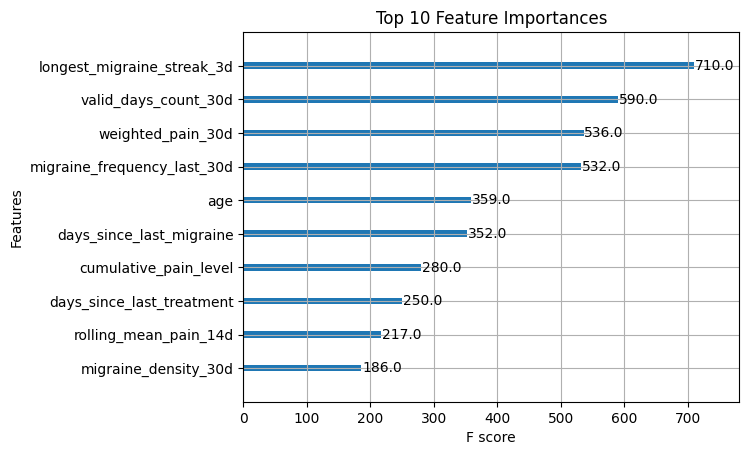

In [ ]:
# Calculate specificity
def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, _, _ = cm.ravel()
    return tn / (tn + fp)

# Optimize threshold
def optimize_threshold(y_true, y_probs):
    thresholds = np.arange(0.1, 1.0, 0.001)
    best_metrics = {'threshold': 0.5, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'specificity': 0}

    for threshold in thresholds:
        y_pred = (y_probs > threshold).astype(int)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        specificity = calculate_specificity(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        if accuracy >= 0.8 and precision >= 0.8 and recall >= 0.8 and specificity >= 0.8:
            if recall + specificity > best_metrics['recall'] + best_metrics['specificity']:
                best_metrics = {
                    'threshold': threshold,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'specificity': specificity
                }

    return best_metrics


categorical_columns = ['gender', 'prevention_treatments']

data_with_dummies = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

data_with_dummies['date'] = pd.to_datetime(data['date'])

user_stats = data_with_dummies.groupby('user_id').agg(
    total_samples=('date', 'count'),
    min_date=('date', 'min'),
    max_date=('date', 'max')
)
user_stats['active_days'] = (user_stats['max_date'] - user_stats['min_date']).dt.days + 1

# Step 1: Remove users with fewer than 5 total records
initial_user_count = data['user_id'].nunique()
initial_record_count = len(data)

filtered_users = user_stats[user_stats['total_samples'] >= 5].index

data_filtered = data_with_dummies[data_with_dummies['user_id'].isin(filtered_users)]

# Step 2
data_filtered = filter_sparse_users(data_filtered)

unique_users = data_filtered['user_id'].unique()

train_users, temp_users = train_test_split(unique_users, test_size=0.4, random_state=42)

val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=42)
train_data = data_filtered[data_filtered['user_id'].isin(train_users)]
val_data = data_filtered[data_filtered['user_id'].isin(val_users)]
test_data = data_filtered[data_filtered['user_id'].isin(test_users)]
X_train = train_data.drop(columns=['next_day_migraine', 'user_id', 'date'], errors='ignore')
y_train = train_data['next_day_migraine']
X_val = val_data.drop(columns=['next_day_migraine', 'user_id', 'date'], errors='ignore')
y_val = val_data['next_day_migraine']
X_test = test_data.drop(columns=['next_day_migraine', 'user_id', 'date'], errors='ignore')
y_test = test_data['next_day_migraine']
X_train = X_train.select_dtypes(include=[int, float, bool])
X_val = X_val.select_dtypes(include=[int, float, bool])
X_test = X_test.select_dtypes(include=[int, float, bool])

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 300, 500],
    'scale_pos_weight': [1, y_train.value_counts(normalize=True).to_dict()[1] / y_train.value_counts(normalize=True).to_dict()[0]]
}
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False)
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_probs = best_model.predict_proba(X_test)[:, 1]
best_threshold_metrics = optimize_threshold(y_test, y_probs)
final_threshold = best_threshold_metrics['threshold']
y_pred = (y_probs > final_threshold).astype(int)

# Final Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = calculate_specificity(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("=== Final Results ===")
print(f"Threshold: {final_threshold:.2f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(classification_report(y_test, y_pred))

# Plot feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


In [ ]:
def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def calculate_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def calculate_metrics_at_thresholds(y_true, y_probs, thresholds):
    results = []

    for threshold in thresholds:
        y_pred = (y_probs > threshold).astype(int)

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        spec = calculate_specificity(y_true, y_pred)
        fpr = calculate_fpr(y_true, y_pred)

        results.append({
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'specificity': spec,
            'fpr': fpr
        })

    return results

def plot_metrics_vs_threshold(y_true, y_probs, optimal_threshold=None):
    thresholds = np.linspace(0.01, 0.99, 99)

    metrics = calculate_metrics_at_thresholds(y_true, y_probs, thresholds)

    accuracy = [m['accuracy'] for m in metrics]
    precision = [m['precision'] for m in metrics]
    recall = [m['recall'] for m in metrics]
    specificity = [m['specificity'] for m in metrics]
    fpr = [m['fpr'] for m in metrics]

    plt.figure(figsize=(12, 8))

    plt.plot(thresholds, accuracy, 'b-', label='Accuracy')
    plt.plot(thresholds, precision, 'g-', label='Precision')
    plt.plot(thresholds, recall, 'r-', label='Recall (Sensitivity)')
    plt.plot(thresholds, specificity, 'c-', label='Specificity')
    plt.plot(thresholds, fpr, 'm-', label='False Positive Rate')

    if optimal_threshold is not None:
        plt.axvline(x=optimal_threshold, color='k', linestyle='--',
                    label=f'Optimal Threshold = {optimal_threshold:.2f}')

    plt.grid(True, alpha=0.3)
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title('Classification Metrics vs. Threshold')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    return plt

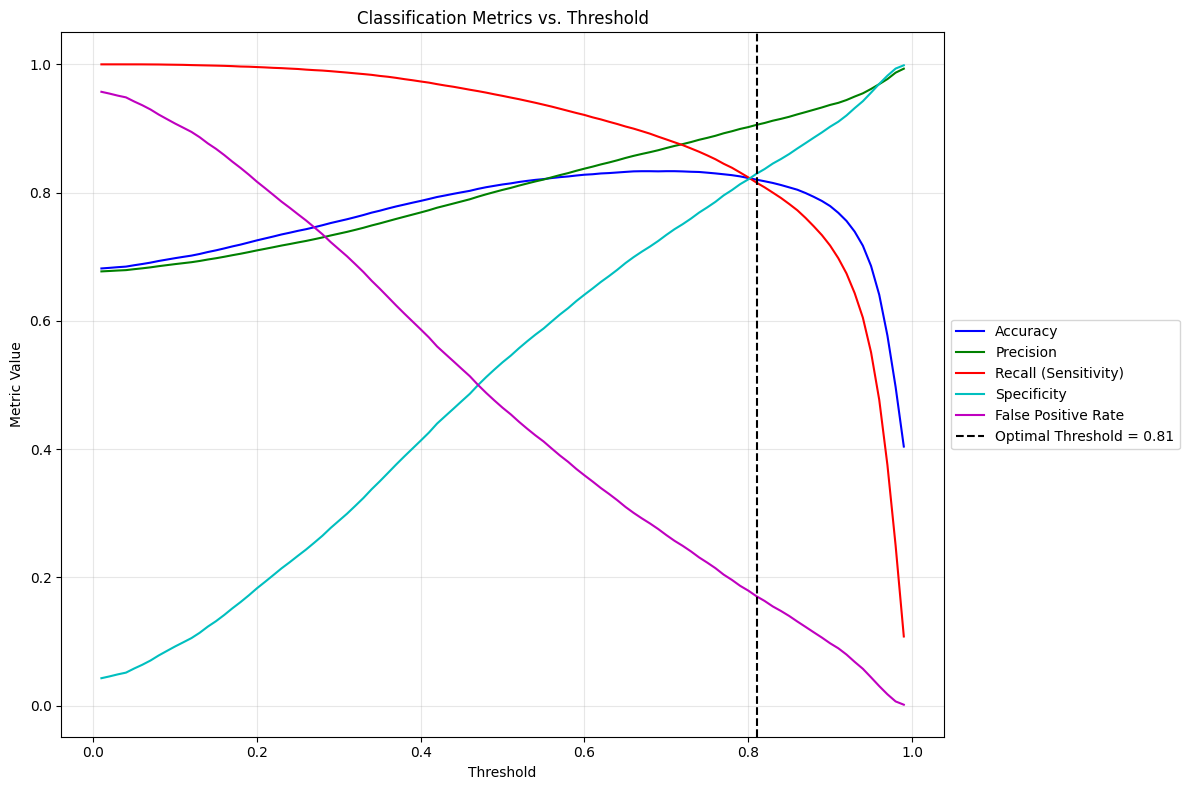

In [ ]:
plot_metrics_vs_threshold(y_test, y_probs, optimal_threshold=final_threshold)
plt.savefig('threshold_metrics.png', dpi=300)
plt.show()

In [ ]:
#### Save the Model

In [ ]:
import pickle
import json

# Save the best model
with open("best_xgboost_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save the best threshold and hyperparameters
best_model_info = {
    "best_threshold": best_threshold_metrics['threshold'],
    "best_hyperparameters": grid_search.best_params_
}

with open("best_model_info.json", "w") as f:
    json.dump(best_model_info, f)


In [ ]:
## See the results of the best model saved

In [ ]:
import pickle
import json
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# ============================
# 1. Load the Trained Model & Configs
# ============================
with open("best_xgboost_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

with open("best_model_info.json", "r") as f:
    model_info = json.load(f)

with open("train_features.json", "r") as f:
    train_features = json.load(f)

loaded_threshold = model_info["best_threshold"]

# ============================
# 2. Load and Prepare the New Dataset
# ============================
# Load new dataset
new_data = data  # change to a new dataset path

# Drop unnecessary columns
X_new = new_data.drop(columns=['user_id', 'date'], errors='ignore')

# Extract true labels
y_new = new_data['next_day_migraine'] if 'next_day_migraine' in new_data else None

# ============================
# 3. Handle Categorical Features with One-Hot Encoding
# ============================
# Convert categorical features to dummy variables
categorical_features = ['gender', 'prevention_treatments']

# Only include existing categorical columns
categorical_features = [col for col in categorical_features if col in X_new.columns]

# One-hot encode categorical features
X_new = pd.get_dummies(X_new, columns=categorical_features, drop_first=True)

# ============================
# 4. Align Features with Training Data
# ============================
# Get model's expected feature names
expected_features = loaded_model.get_booster().feature_names

# Find missing and extra features
missing_features = set(expected_features) - set(X_new.columns)
extra_features = set(X_new.columns) - set(expected_features)

# Debugging: Print unexpected features
print("Missing features in X_new:", missing_features)
print("Extra features in X_new:", extra_features)

# Add missing features with default value (0)
for feature in missing_features:
    X_new[feature] = 0  # Default value can be adjusted if needed

# Remove extra features not in training
X_new = X_new[expected_features]

# Ensure correct feature order
X_new = X_new[expected_features]

# ============================
# 5. Remove Rows with Missing Labels
# ============================
if y_new is not None:
    valid_indices = ~y_new.isna()
    X_new = X_new.loc[valid_indices]
    y_new = y_new.loc[valid_indices]

# ============================
# 6. Make Predictions
# ============================
# Get predicted probabilities
y_new_probs = loaded_model.predict_proba(X_new)[:, 1]

# Apply the threshold
y_new_pred = (y_new_probs > loaded_threshold).astype(int)

# ============================
# 7. Compute Evaluation Metrics
# ============================
def calculate_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, _, _ = cm.ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Avoid division by zero

if y_new is not None:
    accuracy = accuracy_score(y_new, y_new_pred)
    precision = precision_score(y_new, y_new_pred)
    recall = recall_score(y_new, y_new_pred)
    specificity = calculate_specificity(y_new, y_new_pred)

    # Print results
    print("=== Evaluation Metrics ===")
    print(f"Threshold: {loaded_threshold:.2f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

# ============================
# 8. Save Predictions with Corrected DataFrame
# ============================
new_data_filtered = new_data.loc[valid_indices].copy()
new_data_filtered["predicted_label"] = y_new_pred
new_data_filtered["predicted_probability"] = y_new_probs

new_data_filtered.to_csv("first_dataset_predictions.csv", index=False)
print(f"Predictions saved to 'first_dataset_predictions.csv' with {len(new_data_filtered)} rows")


Missing features in X_new: set()
Extra features in X_new: {'next_day_migraine'}
=== Evaluation Metrics ===
Threshold: 0.81
Accuracy: 0.8107
Precision: 0.9049
Recall: 0.8229
Specificity: 0.7798
Predictions saved to 'first_dataset_predictions.csv' with 594117 rows


In [ ]:
import pickle
import json
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# ============================
# 1. Load the Trained Model & Configs
# ============================
with open("best_xgboost_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

with open("best_model_info.json", "r") as f:
    model_info = json.load(f)

with open("train_features.json", "r") as f:
    train_features = json.load(f)

loaded_threshold = model_info["best_threshold"]

# ============================
# 2. Load and Prepare the New Dataset
# ============================
# Load new dataset
new_data = pd.read_csv("full_sparse_data_2_months_all_features.csv")

X_new = new_data
# ============================
# 3. Handle Categorical Features
# ============================
# Convert categorical features to dummy variables
categorical_features = ['gender', 'prevention_treatments']

# Only include existing categorical columns
categorical_features = [col for col in categorical_features if col in X_new.columns]

# One-hot encode categorical features
X_new = pd.get_dummies(X_new, columns=categorical_features, drop_first=True)

# Convert the date column to datetime format
X_new['date'] = pd.to_datetime(X_new['date'])

# Compute user activity statistics
user_stats = X_new.groupby('user_id').agg(
    total_samples=('date', 'count'),
    min_date=('date', 'min'),
    max_date=('date', 'max')
)
user_stats['active_days'] = (user_stats['max_date'] - user_stats['min_date']).dt.days + 1

# Step 1: Remove users with fewer than 5 total records
filtered_users = user_stats[user_stats['total_samples'] >= 5].index
data_filtered = X_new[X_new['user_id'].isin(filtered_users)]

# Step 2: Rolling 20-day window check

X_new = filter_sparse_users(data_filtered)

# Drop unnecessary columns
X_new = new_data.drop(columns=['user_id', 'date'], errors='ignore')

# Extract true labels
y_new = new_data['next_day_migraine'] if 'next_day_migraine' in new_data else None

# ============================
# 4. Align Features with Training Data
# ============================
# Get model's expected feature names
expected_features = loaded_model.get_booster().feature_names

# Find missing and extra features
missing_features = set(expected_features) - set(X_new.columns)
extra_features = set(X_new.columns) - set(expected_features)

# Debugging: Print unexpected features
print("Missing features in X_new:", missing_features)
print("Extra features in X_new:", extra_features)

# Add missing features with default value (0)
for feature in missing_features:
    X_new[feature] = 0  # Default value can be adjusted if needed

# Remove extra features not in training
X_new = X_new[expected_features]

# Ensure correct feature order
X_new = X_new[expected_features]

# ============================
# 5. Remove Rows with Missing Labels
# ============================
if y_new is not None:
    valid_indices = ~y_new.isna()
    X_new = X_new.loc[valid_indices]
    y_new = y_new.loc[valid_indices]

# ============================
# 6. Make Predictions
# ============================
# Get predicted probabilities
y_new_probs = loaded_model.predict_proba(X_new)[:, 1]

# Apply the threshold
y_new_pred = (y_new_probs > loaded_threshold).astype(int)

# ============================
# 7. Compute Evaluation Metrics
# ============================
if y_new is not None:
    accuracy = accuracy_score(y_new, y_new_pred)
    precision = precision_score(y_new, y_new_pred)
    recall = recall_score(y_new, y_new_pred)
    specificity = calculate_specificity(y_new, y_new_pred)

    # Print results
    print("=== Evaluation Metrics ===")
    print(f"Threshold: {loaded_threshold:.2f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

# ============================
# 8. Save Predictions with Corrected DataFrame
# ============================
new_data_filtered = new_data.loc[valid_indices].copy()
new_data_filtered["predicted_label"] = y_new_pred
new_data_filtered["predicted_probability"] = y_new_probs

new_data_filtered.to_csv("new_dataset_predictions.csv", index=False)
print(f"Predictions saved to 'new_dataset_predictions.csv' with {len(new_data_filtered)} rows")


Missing features in X_new: {'gender_3', 'gender_2', 'prevention_treatments_1', 'gender_1'}
Extra features in X_new: {'cumulative_treatment_duration', 'sensitivity_to_sound_2h', 'nausea_medication_2h', 'triptan_not_helpful', 'reyvow_helpful', 'other_devices_not_helpful', 'treatment_duration', 'over_the_counter_2h', 'other_medication_2h', 'ubrelvy_2h', 'ubrelvy_helpful', 'prevention_treatments', 'zavzpret_nasal_spray_not_helpful', 'change_pain_level', 'other_medications_not_helpful', 'nausea_vomiting_2h', 'nasal_spray_not_helpful', 'difficulties_on_speaking_reading_writing', 'diclofenac_potassium_helpful', 'base_functional_disability', 'rolling_mean_pain_level', 'nasal_spray_helpful', 'base_symptoms_started_occur', 'no_medication_2h', 'yawning', 'medication_for_nausea_not_helpful', 'absenteeism', 'gender', 'ubrelvy_not_helpful', 'nurtec_2h', 'nasal_2h', 'irritability', 'diclofenac_potassium_not_helpful', 'sensitivity_to_odors', 'neck_stiffness_2h', 'over_the_counter_helpful', 'food_cravi

In [ ]:
# Predictions users analysis

In [ ]:
predictions_df = pd.read_csv("new_dataset_predictions.csv")

# Ensure user_id is present
if 'user_id' in predictions_df.columns:
    # Compute prediction correctness
    predictions_df['error'] = predictions_df['predicted_label'] != predictions_df['next_day_migraine']

    # Group by user and compute error statistics
    user_error_stats = predictions_df.groupby('user_id').agg(
        total_cases=('error', 'count'),
        false_cases=('error', 'sum'),
        distinct_predicted_values=('predicted_label', 'nunique'),
        distinct_actual_values=('next_day_migraine', 'nunique')  # Count distinct real values
    )

    # Calculate error ratio
    user_error_stats['error_ratio'] = user_error_stats['false_cases'] / user_error_stats['total_cases']

    # Define user groups based on error ratio
    user_groups = {
        'No Error (0)': user_error_stats[user_error_stats['error_ratio'] == 0],
        'Low Error (<0.2)': user_error_stats[user_error_stats['error_ratio'] < 0.2],
        'Moderate Error (0.2-0.7)': user_error_stats[
            (user_error_stats['error_ratio'] >= 0.2) & (user_error_stats['error_ratio'] <= 0.7)
        ],
        'High Error (>0.7)': user_error_stats[user_error_stats['error_ratio'] > 0.7],
        'All Errors (1.0)': user_error_stats[user_error_stats['error_ratio'] == 1.0]
    }

    # Display results
    results = {}
    for group_name, group_data in user_groups.items():
        results[group_name] = {
            'Number of Users': len(group_data),
            'Users with only 1 distinct predicted value': (group_data['distinct_predicted_values'] == 1).sum(),
            'Users with more than 1 distinct predicted value': (group_data['distinct_predicted_values'] > 1).sum(),
            'Users with only 1 distinct actual value': (group_data['distinct_actual_values'] == 1).sum(),
            'Users with more than 1 distinct actual value': (group_data['distinct_actual_values'] > 1).sum(),
        }

    # Convert to DataFrame for display
    results_df = pd.DataFrame.from_dict(results, orient='index')

    # Display the DataFrame
    print(results_df)

else:
    print("Error: 'user_id' column is missing from the dataset.")


                          Number of Users  \
No Error (0)                         1100   
Low Error (<0.2)                     1268   
Moderate Error (0.2-0.7)              826   
High Error (>0.7)                     169   
All Errors (1.0)                       90   

                          Users with only 1 distinct predicted value  \
No Error (0)                                                    1100   
Low Error (<0.2)                                                1172   
Moderate Error (0.2-0.7)                                         135   
High Error (>0.7)                                                 47   
All Errors (1.0)                                                  47   

                          Users with more than 1 distinct predicted value  \
No Error (0)                                                            0   
Low Error (<0.2)                                                       96   
Moderate Error (0.2-0.7)                                         

In [ ]:
results = []
for group_name, group_data in user_groups.items():
    results.append({
            'User Group': group_name,
            'Number of Users': len(group_data),
            'Users with only 1 distinct predicted value': (group_data['distinct_predicted_values'] == 1).sum(),
            'Users with more than 1 distinct predicted value': (group_data['distinct_predicted_values'] > 1).sum(),
            'Users with only 1 distinct actual value': (group_data['distinct_actual_values'] == 1).sum(),
            'Users with more than 1 distinct actual value': (group_data['distinct_actual_values'] > 1).sum(),
    })

# Convert list to DataFrame
results_df = pd.DataFrame(results)

In [ ]:
results_df

,User Group,Number of Users,Users with only 1 distinct predicted value,Users with more than 1 distinct predicted value,Users with only 1 distinct actual value,Users with more than 1 distinct actual value
0,No Error (0),1100,1100,0,1100,0
1,Low Error (<0.2),1268,1172,96,1163,105
2,Moderate Error (0.2-0.7),826,135,691,74,752
3,High Error (>0.7),169,47,122,47,122
4,All Errors (1.0),90,47,43,47,43
